# import Data
## import and install important libraries

In [1]:
from sklearn import preprocessing

In [2]:
import pandas as pd
import numpy as np
import re
import json
from os import listdir
from os.path import join
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns

In [3]:
'''!pip uninstall nltk
!pip install nltk==3.2.5
import nltk'''

'!pip uninstall nltk\n!pip install nltk==3.2.5\nimport nltk'

In [4]:
import emoji#checking if a character is an emoji
import re
import nltk
from nltk.corpus import wordnet
from nltk import word_tokenize 
from nltk.corpus import stopwords 
from nltk import sent_tokenize, word_tokenize
import time

In [5]:
folder=f'/Users/livi/Documents/2020 Fall/data mining/Proposal/Final Paper/Tweets_Half_Cleaned/'
FinFolder=os.listdir(folder)
Frame=[]
for file in FinFolder[:]:
    if (file.endswith('.csv')) & (file!='.DS_Store'):
        One_Frame=pd.read_csv(join(folder,file),lineterminator='\n',index_col=0)
        Frame.append(One_Frame)
T=pd.concat(Frame)
T.reset_index(inplace=True,drop=True)

In [ ]:
#drop
for col in ['location','name','url']:
    T.drop(columns=col,inplace=True)

In [ ]:
#str
for col in ['source','extended_tweet','CountryCode','id','extended_tweet_lemmatized']:
    T[col]=T[col].astype(str)
#num
for col in ['friends_count','followers_count','neg','neu','pos','compound']:
    T[col]=T[col].astype(float)
#apply
for col in ['SDG','hashtags']:
    T[col]=T[col].apply(eval)

In [ ]:
T.info()

# Data Cleaning

### Generate user information

### Detect Bot and Consider label Bot
1. interarrival time is smaller than 5 seconds(Tested, mainly small intervals are caused by long tweets)
2. other weird resource (source from bot may have interarrival time much longer 5 sec) Most effective method
3. number of tweets per day (statuses_count, not used here, because there are accounts which frequently tweets)

number of Influencer:A micro-influencer is someone who has between 1,000 to 100,000 followers

In [ ]:
#Assign user type
T['UserType']=''
screen_name_of_bots=list(T[T['source'].str.contains('bot')]['screen_name'].unique())
screen_name_of_bots.extend(['trendsinAI','form_bot','UDHROne257_247','globalhealthbot'])
screen_name_of_bots.extend(list(T[T['screen_name'].str.contains('retweet',case=False)]['screen_name'].unique()))
BFF=T[['screen_name','friends_count','followers_count']].groupby(['screen_name']).agg({'friends_count':'max','followers_count':'max'}).reset_index()
#assign user
screen_name_of_user=list(BFF[(BFF['followers_count']<=800)]['screen_name'].unique())
T.loc[(T['screen_name'].isin(screen_name_of_user))& (~ T['screen_name'].isin(screen_name_of_bots)),'UserType']='user'
#assign influencer
screen_name_of_influencer=list(BFF[(BFF['followers_count']>800)]['screen_name'].unique())
screen_name_of_influencer.extend(list(T[T['screen_name'].str.contains('news',case=False)]['screen_name'].unique()))
T.loc[(T['screen_name'].isin(screen_name_of_influencer)) & (~ T['screen_name'].isin(screen_name_of_bots)),'UserType']='influencer'
#assign bots
T.loc[T['screen_name'].isin(screen_name_of_bots),'UserType']='bot'

### include other SDG according to the keywords

In [ ]:
keyword_list=[['#poverty'],['#zerohunger'],['#globalhealth'],['#education'],['#genderequality'],['#water'],['#energy'],['#decentwork'],['#economicgrowth','#ideas'],['#socialjustice'],['#sustainablecities'],['#sparetosave'],['#climateaction'],['#ocean'],['#lifeonland'],['#justice','#peace']]
for i in range(16):
    for ii in keyword_list[i]:
        for iii in T[T['extended_tweet'].str.contains(ii,case=False)].index:
            T.loc[iii,'SDG'].append('SDG'+str(i+1))
        #print(i+1,keyword_list[i],ii)

###  Generate labels topic

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
'''PopSDGs=['SDG'+str(i) for i in [4,5,7,2,16]]
for PopSDG in PopSDGs:
  searchTerm = PopSDG
  TextExt=T[[searchTerm in x for x in T['SDG']]]
  #parameter set-up
  count_vect=CountVectorizer(max_df=0.8,min_df=2,stop_words='english')
  LDA = LatentDirichletAllocation(n_components=5, random_state=42)
  #topic modeling
  tweet_matrix=count_vect.fit_transform(TextExt['extended_tweet_lemmatized'].values.astype('U'))
  LDA.fit(tweet_matrix)
  #print results
  '''  for i in top_topic_words:
      print(count_vect.get_feature_names()[i])'''
  for i,topic in enumerate(LDA.components_):
      print(f'Top 20 words for {PopSDG} topic #{i}:')
      print([count_vect.get_feature_names()[i] for i in topic.argsort()[-20:]])
      print('\n')
  print('*'*50)
  #put topic back to tweets
  topic_values = LDA.transform(tweet_matrix)
  T[PopSDG+'Topic']=None
  #putinto the main matrix
  T.loc[TextExt.index,PopSDG+'Topic']=topic_values.argmax(axis=1)'''

# Analysis
## Generate different type of users

In [ ]:
Users=T[['screen_name','id','UserType','source']].groupby('screen_name').agg({'id':'count','UserType':'last','source':'last'})

In [ ]:
Users.sort_values('id',ascending=False,inplace=True)
Users.reset_index(inplace=True)

In [ ]:
cri_bot=Users['UserType']=='bot'
cri_user=Users['UserType']=='user'
cri_influencer=Users['UserType']=='influencer'

In [ ]:
set(Users['screen_name'].to_list()[:30]).intersection(set(Users[cri_user]['screen_name'].to_list()[:15]))

In [ ]:
plt.figure(figsize=(15,8))
plt.bar(Users['screen_name'].to_list()[:40],Users['id'].to_list()[:40])
plt.title('All', fontsize=15)
plt.xticks(rotation=90)
plt.show()

plt.figure(figsize=(15,8))
plt.bar(Users[cri_bot]['screen_name'].to_list()[:15],Users[cri_bot]['id'].to_list()[:15])
plt.title('Bot', fontsize=15)
plt.xticks(rotation=90)
plt.show()

plt.figure(figsize=(15,8))
plt.bar(Users[cri_user]['screen_name'].to_list()[:30],Users[cri_user]['id'].to_list()[:30])
plt.title('User', fontsize=15)
plt.xticks(rotation=90)
plt.show()

plt.figure(figsize=(15,8))
plt.bar(Users[cri_influencer]['screen_name'].to_list()[:15],Users[cri_influencer]['id'].to_list()[:15])
plt.title('Influencer', fontsize=15)
plt.xticks(rotation=90)
plt.show()

In [ ]:
T[['screen_name','id','UserType','source']].groupby('UserType').agg({'id':'count','source':'last','screen_name':'last'})

## Generate National Graph
### import libraty and geojson

In [ ]:
import folium

In [ ]:
with open('/Users/livi/Git/Tweepy-data-mining/countries.geojson') as f:
  geodata = json.load(f)

In [ ]:
holdlist=[]
allcountries=[]
for k,i in enumerate(geodata['features']):
  allcountries.append(i['properties']['ADMIN'])
  if i['properties']['ADMIN'] in T['CountryCode'].tolist():
    holdlist.append(i['properties']['ADMIN'])

In [ ]:
for i,k in enumerate(T['CountryCode']):
    if '[' in str(k):
        T.loc[i,'CountryCode']='nan'

In [ ]:
print('Overlap of geojson and countrycode:',len(np.unique(np.array(holdlist))))
print('CountryCode in data:',len(T['CountryCode'].unique()))
print('Geojson we have:',len(np.unique(allcountries)))
df1=pd.DataFrame(allcountries)
df1.index=df1[0]
df1.columns=['geojson']
df2=pd.DataFrame(T['CountryCode'].unique())
df2.index=df2[0]
df2.columns=['googlemap']

In [ ]:
#countries could not be identified
countrynotincluded=list(set(T['CountryCode'].unique())-set(np.unique(np.array(holdlist))))
sum(T['CountryCode'].isin(countrynotincluded)),len(T)

In [ ]:
'''contriesLists=pd.concat([df1, df2], axis=1, sort=False,join='outer')
D=contriesLists[contriesLists['googlemap']!=contriesLists['geojson']]'''

### Plot Frequency Map and sccatter plot

In [ ]:
PP=T[T['UserType']=='user']
PP=PP[['CountryCode', 'id']].groupby('CountryCode').count()
PP.reset_index(inplace=True)
PP.sort_values('id',ascending=False,inplace=True)
PP['count']=np.log10(PP['id'])

In [ ]:
PP.head()

In [ ]:
m = folium.Map(location=[0, 0], zoom_start=2)
folium.Choropleth(
    geo_data=geodata,
    name='choropleth',
    data=PP,
    columns=['CountryCode', 'count'],
    key_on='feature.properties.ADMIN',
    fill_color='YlGn',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='# of Tweets'
).add_to(m)

folium.LayerControl().add_to(m)
m

In [ ]:
plt.figure(figsize=(20,10))
#plt.bar(PP.CountryCode[:30],PP.text[:30])
plt.scatter(range(len(PP.CountryCode)),PP['count'])
plt.xlabel('Country',fontsize=20)
plt.xticks(rotation=90,fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('log_10 Frequency',fontsize=20)
plt.tight_layout()
#plt.savefig('1023place dis.jpg')
plt.show()

In [ ]:
plt.figure(figsize=(20,10))
plt.bar(PP.CountryCode[:30],PP.id[:30])
plt.xlabel('Country',fontsize=20)
plt.xticks(rotation=90,fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('Frequency',fontsize=20)
plt.tight_layout()
#plt.savefig('1023place dis.jpg')
plt.show()

### plot SDG Map and heatmap table 


In [ ]:
#Country and SDG distribution
CS=T[['CountryCode','SDG']]
SDs={}
for coun in CS['CountryCode'].unique():
    SDs[coun]={'SDG'+str(i+1):0 for i in range(17)}
    temp=CS[CS['CountryCode']==coun]['SDG']
    for S in temp:
        for SS in S:
            try:
              SDs[coun][SS]+=1
            except:
                pass  

In [ ]:
selected_country=['United States','United Kingdom','Australia','India','Nigeria','Kenya']
SD_Coun_HM=pd.DataFrame({i:SDs[i] for i in selected_country})
rowname,colname=SD_Coun_HM.columns,SD_Coun_HM.index
#prepare label
HM_label=SD_Coun_HM.div(SD_Coun_HM.sum(axis=0),axis=1).T.values
#prepare data
SD_Coun_HM=pd.DataFrame(preprocessing.MinMaxScaler().fit_transform(SD_Coun_HM).T)
SD_Coun_HM.index,SD_Coun_HM.columns=rowname,colname
#plt
plt.figure(figsize=(20,4))
axhm = plt.gca()
axhm.xaxis.set_ticks_position('top')
cmp=sns.color_palette("Blues", as_cmap=True)
sns.heatmap(SD_Coun_HM,cmap=cmp,vmax=1.2,linewidths=1,annot=HM_label,fmt='.1%',cbar=False,annot_kws={"fontsize":13})
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

In [ ]:
def multi_dict_max(dict):
    max_value=max(dict.values())
    return [i for i in dict.keys() if dict[i]==max_value]
def multi_dict_min(dict):
    min_value=min(dict.values())
    return [i for i in dict.keys() if dict[i]==min_value]

In [ ]:
#Color of each SDG
Colors=['#e4253c','#dea73a','#4c9f45','#c5202e','#f0412b','#29bee2','#fac315','#a21c44','#f26a2c','#dd1768','#f99d27','#be8b2c','#417f45','#1c97d3','#5dbb47','#06699e','#18486b']
SDGcolor={'SDG'+str(i+1):Colors[i] for i in range(17)}

#statistic of some selected countries
#statistic of some selected countries
EsC_count={}
for i in SDs.keys():
    if i==i and i not in ["['SDG14']","[]"]:
        try:
            EsC_count[i]={'sum':0,'top':0,'percentage':0}
            EsC_count[i]['sum']=sum(SDs[i].values())
            if EsC_count[i]['sum']!=0:
                EsC_count[i]['percentage']=round(max(SDs[i].values())/sum(SDs[i].values())*100,1)
            else:
                EsC_count[i]['percentage']=0
            EsC_count[i]['top']=multi_dict_max(SDs[i])
            EsC_count[i]['bottom']=multi_dict_min(SDs[i])
            #EsC_count[i]['geo']=[geodict[i]['lat'],geodict[i]['lng']]
        except:
            raise
#select some countries
ggdataEsC=geodata
select=[]
for i in range(len(ggdataEsC['features'])):
    if ggdataEsC['features'][i]['properties']['ADMIN'] in EsC_count.keys():
        select.append(i)
ggdataEsC['features']=[ggdataEsC['features'][i] for i in select]

In [ ]:
#plot the graph most popular
def stfunc(features):
    return {'fillOpacity': 0.9,'weight': 0,'fillColor':SDGcolor[EsC_count[features['properties']['ADMIN']]['top'][0]]}
def gengeo(coun):
    f={'features':[ggdataEsC['features'][i]] for i in range(len(ggdataEsC['features'])) if ggdataEsC['features'][i]['properties']['ADMIN']==coun}
    f['type']='FeatureCollection'
    return f

n = folium.Map(location=[50, 10], zoom_start=2.2,tiles='OpenStreetMap')
folium.GeoJson(ggdataEsC,name='United States',style_function=stfunc).add_to(n)
n

In [ ]:
#plot the graph least popular sdg
def stfunc(features):
    return {'fillOpacity': 0.9,'weight': 0,'fillColor':SDGcolor[EsC_count[features['properties']['ADMIN']]['bottom'][0]]}
def gengeo(coun):
    f={'features':[ggdataEsC['features'][i]] for i in range(len(ggdataEsC['features'])) if ggdataEsC['features'][i]['properties']['ADMIN']==coun}
    f['type']='FeatureCollection'
    return f

o = folium.Map(location=[50, 10], zoom_start=2.2,tiles='OpenStreetMap')
folium.GeoJson(ggdataEsC,name='United States',style_function=stfunc).add_to(o)
o

In [ ]:
#### Developing and Developed Country Compare (vote the top then select)
#define developed country and developing country
developed_country='Canada,United States,Australia,Japan,New Zealand,Austria,Belgium,Denmark,Finland,France,Germany,Greece,Ireland,Italy,Luxembourg,Netherlands,Portugal,Spain,Sweden,United Kingdom,Bulgaria,Croatia,Cyprus,Czechia,Estonia,Hungary,Latvia,Lithuania,Malta,Poland,Romania,Slovakia,Slovenia,Iceland,Norway,Switzerland'.split(',')
transition='Albania,Bosnia and Herzegovina,Montenegro,North Macedonia,Serbia,Armenia,Azerbaijan,Belarus,Georgia,Kazakhstan,Kyrgyzstan,Moldova,Russia,Tajikistan,Turkmenistan,Ukraine,Uzbekistan'.split(',')
developing_country='Algeria,Egypt,Libya,Mauritania,Morocco,Sudan,Tunisia,Cameroon,Central African Republic,Chad,Republic of the Congo,Equatorial Guinea,Gabon,São Tomé and Príncipe,Burundi,Comoros,Democratic Republic of the Congo,Djibouti,Eritrea,Ethiopia,Kenya,Madagascar,Rwanda,Somalia,South Sudan,Uganda,Tanzania,Angola,Botswana,Eswatini,Lesotho,Malawi,Mauritius,Mozambique,Namibia,South Africa,Zambia,Zimbabwe,Benin,Burkina Faso,Cape Verde,Côte d\'Ivoire,The Gambia,Ghana,Guinea,Guinea-Bissau,Liberia,Mali,Niger,Nigeria,Senegal,Sierra Leone,Togo,Brunei,Cambodia,China,North Korea,Fiji,Hong Kong,Indonesia,Kiribati,Laos,Malaysia,Mongolia,Myanmar (Burma),Papua New Guinea,Philippines,South Korea,Samoa,Singapore,Solomon Islands,Taiwan,Thailand,Timor-Leste,Vanuatu,Vietnam,Afghanistan,Bangladesh,Bhutan,India,Iran,Maldives,Nepal,Pakistan,Sri Lanka,Bahrain,Iraq,Israel,Jordan,Kuwait,Lebanon,Oman,Qatar,Saudi Arabia,Palestine,Syria,Turkey,United Arab Emirates,Yemen,The Bahamas,Barbados,Belize,Guyana,Jamaica,Suriname,Trinidad and Tobago,Costa Rica,Cuba,Dominican Republic,El Salvador,Guatemala,Haiti,Honduras,Mexico,Nicaragua,Panama,Argentina,Bolivia,Brazil,Chile,Colombia,Ecuador,Paraguay,Peru,Uruguay,Venezuela'.split(',')



### vote the top then select

In [ ]:
def talkmost(country,T):
  for i in list(set(country)-set(SDs.keys())):
    country.remove(i)
  country_SDs={i:SDs[i]for i in country}
  country_TopSDG=[]
  for i in country_SDs:
    try:
      if sum(country_SDs[i].values())>20 & max(country_SDs[i].values())>1:#make sure more than 1 tweets in the max column
        MAXtop=max(country_SDs[i].values())
        country_TopSDG.extend([ii for ii in country_SDs[i] if country_SDs[i][ii]==MAXtop])    
    except:
      pass
  country_TopSDG={k:v for k,v in sorted(Counter(country_TopSDG).items(),key=lambda x:x[1],reverse=True)}
  plt.bar(country_TopSDG.keys(),country_TopSDG.values())
  plt.title(T)
  print(list(country_TopSDG.keys()))
  plt.show()

def talkleast(country,T):
  for i in list(set(country)-set(SDs.keys())):
    country.remove(i)
  country_SDs={i:SDs[i]for i in country}
  country_TopSDG=[]
  for i in country_SDs:
    try:
      if sum(country_SDs[i].values())>20:#make sure more than 1 tweets in the max column
        MINtop=min(country_SDs[i].values())
        country_TopSDG.extend([ii for ii in country_SDs[i] if country_SDs[i][ii]==MINtop])
        #print(MINtop)
    except:
      pass
  country_TopSDG={k:v for k,v in sorted(Counter(country_TopSDG).items(),key=lambda x:x[1],reverse=True)}
  plt.bar(country_TopSDG.keys(),country_TopSDG.values())
  plt.title(T)
  print(list(country_TopSDG.keys()))
  plt.show()

In [ ]:
plt.figure(figsize=(15,5))
talkmost(developed_country,'Developed talk Most')
plt.figure(figsize=(15,5))
talkleast(developed_country,'Developed talk Least')
plt.figure(figsize=(15,5))
talkmost(developing_country,'developing talk Most')
plt.figure(figsize=(15,5))
talkleast(developing_country,'developing talk Least')
plt.figure(figsize=(15,5))
talkmost(transition,'Transition talk Most')
plt.figure(figsize=(15,5))
talkleast(transition,'Transition talk Least')

#### Based on Frequency

In [ ]:
def toptalkfreq(countrylist,T):
  SD_Co=pd.DataFrame({i:SDs[i] for i in countrylist})
  SD_Co.sum(axis=1).sort_values(ascending=False).plot(kind='bar')
  l=list(SD_Co.sum(axis=1).sort_values(ascending=False).index)
  #l = [i.strip('\'\'') for i in l]
  print(l)

  plt.title(T)
  plt.show()

In [ ]:
plt.figure(figsize=(10,5))
toptalkfreq(developed_country,'Developed Countries')
plt.figure(figsize=(10,5))
toptalkfreq(developing_country,'Developing Countries')

## Top SDG based on Country

In [ ]:
top5EnCoun=PP.CountryCode[:30].tolist()
for topcount in top5EnCoun:
  plt.figure(figsize=(14,7))
  plt.bar(SDs[topcount].keys(),SDs[topcount].values())
  plt.title(topcount,fontsize=25,weight='bold')
  plt.xlabel('SDG',fontsize=25,weight='bold')
  plt.xticks(fontsize=20,weight='bold',rotation=90)
  plt.yticks(fontsize=20,weight='bold',rotation=90)
  plt.ylabel('Frequency',fontsize=25,weight='bold')
  plt.tight_layout()
  #plt.savefig(topcount+'.jpg')

## Frequency of SDG

In [46]:
TT=T[['extended_tweet', 'SDG','CountryCode']]
TT['length']=[len(i) for i in TT['SDG']]
TT=TT[[len(i)>0 for i in TT['SDG']]]
TT.reset_index(drop=True,inplace=True)
print(TT.shape)
TT.head()

(384725, 4)


,extended_tweet,SDG,CountryCode,length
0,2019 was the second warmest year on record .\n...,[SDG13],nan,1
1,@fayway @fit4duty_ethics @drumeshprabhu @talal...,[SDG16],United Kingdom,1
2,what is the nutritional composition of the mos...,[SDG2],United States,1
3,we are excited to share our partner @bildungsh...,[SDG4],nan,1
4,we have the knowledge and the tools to prevent...,"[SDG16, SDG16]",United States,2


In [47]:
#Clean up the string
Tdict={}
for i in TT['SDG'].to_list():
    for ii in i:
        if ii in Tdict:
            Tdict[ii]+=1
        else:
            Tdict[ii]=1
#Tdict['']+=Tdict['']
try:
  Tdict['SDG1']+=Tdict['SDG01']
  Tdict['SDG8']+=Tdict['SDG08']
  Tdict['SDG6']+=Tdict['SDG64']
  Tdict['SDG6']+=Tdict['SDG06']
  Tdict['SDG4']+=Tdict['SDG04']
  del Tdict['SDG01']
  del Tdict['SDG04']
  #del Tdict['SDG4ALL']
  #del Tdict['SDG4B']
  #del Tdict['SDG4IT']
  #del Tdict['SDG4SURVEY']
  #del Tdict['SDG4PT7']
  del Tdict['SDG06']
  del Tdict['SDG64']
  del Tdict['SDG08']
  del Tdict['SDG18']
  del Tdict['SDG200']
  del Tdict['SDG2030']
  del Tdict['SDG2020']
  del Tdict['SDG2000']
  del Tdict['SDG632']
  del Tdict['SDG20']
  del Tdict['SDG0']
  del Tdict['SDG19']

except:
  pass
Tdict={k:v for k,v in sorted(Tdict.items(), key=lambda x: x[1],reverse=True)}
sorted(Tdict)

['SDG1',
 'SDG10',
 'SDG11',
 'SDG12',
 'SDG13',
 'SDG14',
 'SDG15',
 'SDG16',
 'SDG17',
 'SDG2',
 'SDG3',
 'SDG4',
 'SDG5',
 'SDG6',
 'SDG7',
 'SDG8',
 'SDG9']

dict_keys(['SDG13', 'SDG4', 'SDG16', 'SDG7', 'SDG6', 'SDG14', 'SDG1', 'SDG5', 'SDG2', 'SDG3', 'SDG10', 'SDG9', 'SDG12', 'SDG8', 'SDG11', 'SDG17', 'SDG15'])


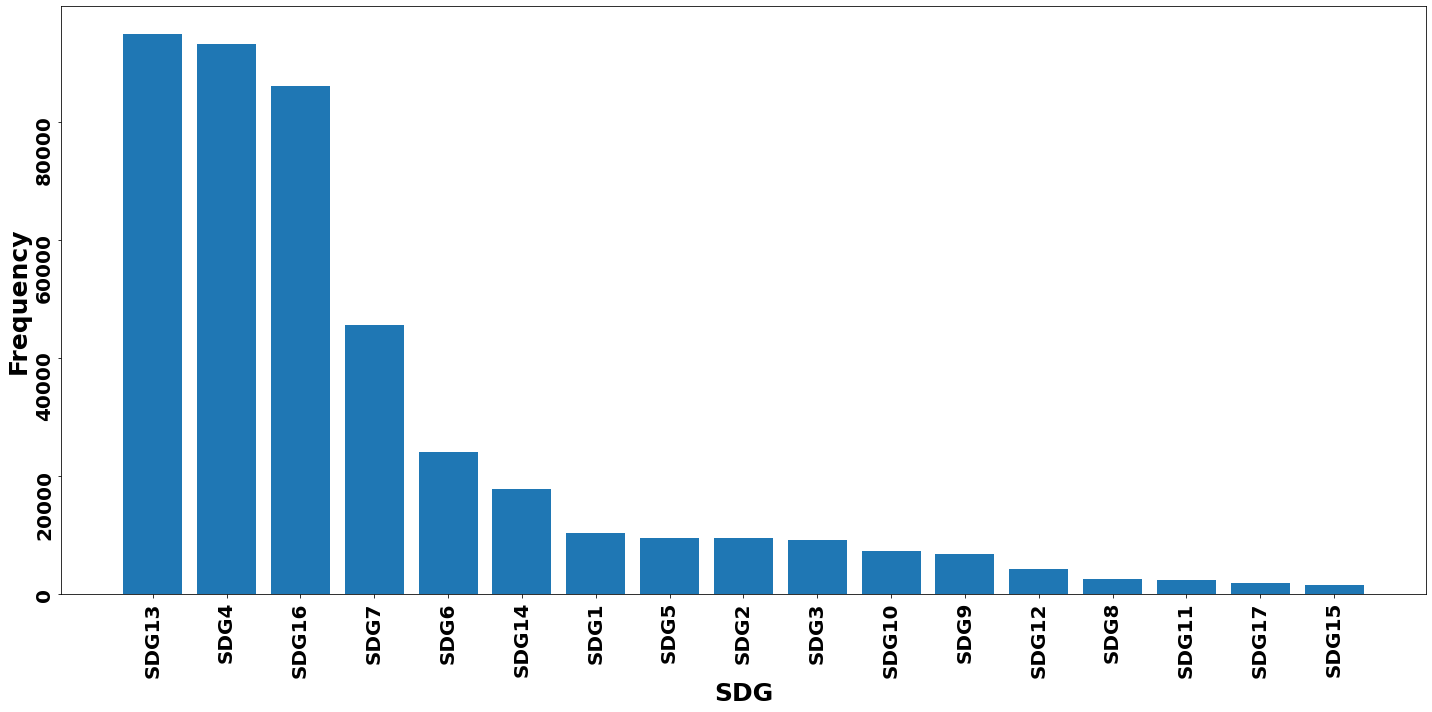

In [48]:
print(Tdict.keys())
plt.figure(figsize=(20,10))
plt.bar(Tdict.keys(),Tdict.values())
plt.xlabel('SDG',fontsize=25,weight='bold')
plt.xticks(fontsize=20,weight='bold',rotation=90)
plt.yticks(fontsize=20,weight='bold',rotation=90)
plt.ylabel('Frequency',fontsize=25,weight='bold')
plt.tight_layout()
#plt.savefig('SDG popularity.jpg')
plt.show()

## Sentiment analysis

### Sentiment on user, activist, and org

In [ ]:
T[T['CountryCode'].isin(['United States','United Kingdom','Australia','Nigeria'])].groupby(['CountryCode','type']).apply(lambda x: len(set(x['id'])))

In [ ]:
#generate number of organization, activists and user
T[T['CountryCode'].isin(['United States','United Kingdom','Australia','Nigeria'])].groupby(['CountryCode','type']).apply(lambda x: len(set(x['id'])))

In [ ]:
Sentiment_Type_Country=T[T['CountryCode'].isin(['United States','United Kingdom','Australia','Nigeria'])].groupby(['CountryCode','type']).describe()
Sentiment_Type_Country['compound']

Sentiment_Type_Country_unique=T[T['CountryCode'].isin(['United States','United Kingdom','Australia','Nigeria'])].drop_duplicates(subset='extended_tweet').groupby(['CountryCode','type']).describe()
Sentiment_Type_Country_unique['compound']

In [ ]:
#### LIWC analysis on User and Activists

In [ ]:
TLIWC=pd.read_csv('/s3/Tweets files/LIWC2015 Results (T.csv).csv')

In [ ]:
pd.DataFrame(TLIWC.iloc[0])[:33]

In [ ]:
TLIWC.rename(columns={'L':'extended_tweet', 'AB':'id','AF':'type','P':'CountryCode'},inplace=True)

In [ ]:
# LIWC columns
AffectWords=['posemo', 'negemo', 'anx', 'anger', 'sad']
CognetiveProcess=['insight', 'cause', 'discrep', 'tentat', 'certain', 'differ']
PerpetualProcesses=['see', 'hear', 'feel']
BiologicalProcesses=['bio', 'body', 'health', 'sexual', 'ingest']
CoreDrivesandNeeds=['affiliation', 'achieve', 'power', 'reward', 'risk']
TimeOrientation=['focuspast', 'focuspresent', 'focusfuture']
Relativity=['motion', 'space', 'time']
PersonalConcerns=['work', 'leisure', 'home', 'money', 'relig', 'death']

In [ ]:
desired_col=['extended_tweet','id','type','CountryCode']
for i in ['AffectWords','CognetiveProcess','PerpetualProcesses','BiologicalProcesses','CoreDrivesandNeeds','TimeOrientation','Relativity','PersonalConcerns']:
  desired_col.extend(eval(i))
TLIWCsmall=TLIWC[desired_col]
TLIWCsmall.drop(index=TLIWCsmall[pd.isnull(TLIWCsmall['extended_tweet'])].index,inplace=True)
TLIWCsmall.drop(index=TLIWCsmall[pd.isnull(TLIWCsmall['id'])].index,inplace=True)
TLIWCsmall.reset_index(drop=True,inplace=True)

In [ ]:
TLIWCsmall.head(2)

In [ ]:
TLIWCsmall_COUN=TLIWCsmall[TLIWCsmall['CountryCode'].isin(selected_country)]

In [ ]:
TLIWCsmall_COUN.drop_duplicates(subset=p['extended_tweet'],inplace=True)

In [ ]:
Activists=TLIWCsmall_COUN[['id','CountryCode','type']].drop_duplicates(subset='id').groupby(['CountryCode','type']).count()
Activists.rename(columns={'is':'Count'},inplace=True)

In [ ]:
LIWC=TLIWCsmall_COUN.groupby(['CountryCode','type']).mean()

In [ ]:
LIWC_ACT=Activists.join(LIWC)
LIWC_ACT.rename(columns={'id':'Count'},inplace=True)

In [ ]:
col_name=['Count']
col_name.extend(AffectWords)
col_name.extend(TimeOrientation)
LIWC_ACT.loc[:,col_name]

LIWC_ACT.loc[:,CoreDrivesandNeeds]

In [ ]:
#### Sentiment on one of the SDG

In [ ]:
T.groupby('SDG4Topic')['compound'].describe()

In [ ]:
for i in ['SDG4Topic','SDG5Topic','SDG7Topic','SDG2Topic']:
    T[[i,'compound']].boxplot(figsize=(12,8),by=i,boxprops=dict(linestyle='-', linewidth=3),flierprops=dict(linestyle='-', linewidth=3),
                 medianprops=dict(linestyle='-', linewidth=3),
                 whiskerprops=dict(linestyle='-', linewidth=3),
                 capprops=dict(linestyle='-', linewidth=3))

    plt.title('Boxplot grouped by '+i,fontsize=25,weight='bold')
    plt.xlabel(i,fontsize=25,weight='bold')
    plt.xticks(fontsize=20,weight='bold')
    plt.yticks(fontsize=20,weight='bold')
    plt.ylabel('',fontsize=25,weight='bold')
    plt.tight_layout()
    plt.show()

plt.scatter(range(len(T.groupby('CountryCode')['compound'])),sorted(T.groupby('CountryCode')['compound'].mean()))
plt.show()

In [ ]:
### Strong against SDGs

In [ ]:
def PrintTopic(df, topicnum=5,keywds=20):
  #parameter set-up
  count_vect=CountVectorizer(max_df=0.8,min_df=2,stop_words='english')
  LDA = LatentDirichletAllocation(n_components=topicnum, random_state=42)
  #topic modeling
  tweet_matrix=count_vect.fit_transform(df['extended_tweet_lemmatized'].values.astype('U'))
  LDA.fit(tweet_matrix)
  #print results
  '''  for i in top_topic_words:
      print(count_vect.get_feature_names()[i])'''
  for i,topic in enumerate(LDA.components_):
      print(f'Top 20 words for {PopSDG} topic #{i}:')
      print([count_vect.get_feature_names()[i] for i in topic.argsort()[-keywds:]])
      print('\n')
  print('*'*50)
  #put topic back to tweets
  topic_values = LDA.transform(tweet_matrix)
  df['HateTopic']=None
  #putinto the main matrix
  df.loc[df.index,'HateTopic']=topic_values.argmax(axis=1)
  return df


In [ ]:
print(*T[T['extended_tweet'].str.contains('propaganda')]['extended_tweet'].drop_duplicates().tolist(),sep='\n'+'-'*100+'\n')
print(*T[T['extended_tweet'].str.contains('nosdgs')]['extended_tweet'].tolist(),sep='\n'+'-'*100+'\n')
print(*T[T['extended_tweet'].str.contains('hypocrite')]['extended_tweet'].tolist(),sep='\n'+'-'*100+'\n')
print(*T[T['extended_tweet'].str.contains('stopsdg')]['extended_tweet'].tolist(),sep='\n'+'-'*100+'\n')
print(*T[T['extended_tweet'].str.contains('globalism')]['extended_tweet'].drop_duplicates().tolist(),sep='\n'+'-'*100+'\n')
print(*T[T['extended_tweet'].str.contains('hypocrisy')]['extended_tweet'].drop_duplicates().tolist(),sep='\n'+'-'*100+'\n')
print(*T[T['extended_tweet'].str.contains('plandemic')]['extended_tweet'].drop_duplicates().tolist(),sep='\n'+'-'*100+'\n')

In [ ]:
StrongAgainst=T[T['extended_tweet'].str.contains('propaganda|nosdgs|hypocrite|stopsdgs|globalism|hypocrisy|plandemic|pcrtestpandemic|thegreatreset|scamdemic|pcrtestpandemic')].drop_duplicates(subset='extended_tweet')#['extended_tweet']#.drop_duplicates()

In [ ]:
StrongAgainst_HT=[]
for i in StrongAgainst['hashtags'].tolist():
  StrongAgainst_HT.extend(i)
StrongAgainst_HT=Counter(StrongAgainst_HT)
StrongAgainst_HT={i:k for i,k in sorted(StrongAgainst_HT.items(),key=lambda x:x[1],reverse=True)}

del StrongAgainst_HT['#sdgs']
del StrongAgainst_HT['#agenda2030']
del StrongAgainst_HT['#2030agenda']
del StrongAgainst_HT['#sdg']


In [ ]:
plt.figure(figsize=(15,8))
plt.bar(list(StrongAgainst_HT.keys())[:30],list(StrongAgainst_HT.values())[:30])
plt.xticks(rotation=90)
plt.show()
list(StrongAgainst_HT.keys())[:30]

In [ ]:
topnum=3
StrongAgainst=PrintTopic(StrongAgainst,topnum,20)

for i in range(topnum):
  print(*StrongAgainst[StrongAgainst['HateTopic']==i].sample(2)['extended_tweet'].tolist(),sep='\n'+'-'*100+'\n')
  print('*'*100)

plt.hist(StrongAgainst['HateTopic'])
plt.show()